In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

p_data_raw = os.path.abspath('data') # raw data path

user_table   = pd.read_csv(p_data_raw+'/user_table.csv')
test_results = pd.read_csv(p_data_raw+'/test_results.csv',index_col=0)

# Goal
To evaluate whether a pricing test running on the site has been successful (focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find)  
  
# Questions:  
1. Should the company sell its software for 39 or 59?  
 Sell price at 59 will decrease conversion rate but increases revenue. The company can sell its software for 59.
  
2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?  
 Friend referral from iOS platform (iphone/ipad) has the strongest impact on conversion rate; google ads and facebook ads are pretty effective too.
  
3. The VP of Product feels that the test has been running for too long and she should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days would you have stopped the test? Please, explain why.  
 Yes I agree. I will stop the test a day 7 because the p-value of the wilcoxon test dropped to <0.01 at that day (2015-03-29), which indicates the increase of price harms the conversion rate significantly but increases revenue.

## Data
### Table: user_table

In [2]:
print('user_table:\n')
print(user_table.head())
# user_table.info()
# user_table.describe()

print('\nuser_table missing value:\n')
print(user_table.isnull().sum())
# sns.heatmap(user_table.isnull(),yticklabels=False,cbar=False)

user_table:

   user_id         city country    lat    long
0   510335      Peabody     USA  42.53  -70.97
1    89568         Reno     USA  39.54 -119.82
2   434134       Rialto     USA  34.11 -117.39
3   289769  Carson City     USA  39.15 -119.74
4   939586      Chicago     USA  41.84  -87.68

user_table missing value:

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64


*Note: no missing data*

In [3]:
print('column "country" and "city":\n')
print(user_table.groupby('country')['city'].value_counts())
# user_table.groupby('city')['user_id'].count().sort_values(ascending=False)
# user_table.groupby('country')['user_id'].count()

column "country" and "city":

country  city                    
USA      New York                    25748
         Chicago                      7153
         Houston                      6706
         San Antonio                  4633
         Los Angeles                  4141
         San Jose                     3354
         Indianapolis                 3217
         Jacksonville                 2905
         Philadelphia                 2541
         Las Vegas                    2426
         Austin                       2292
         Seattle                      2204
         Oklahoma City                1796
         Charlotte                    1768
         Tucson                       1732
         Virginia Beach               1712
         Oakland                      1686
         Nashville                    1581
         Mesa                         1557
         Memphis                      1540
         Minneapolis                  1466
         Fort Worth              

In [4]:
print('Unique City numbers are: ', user_table['city'].nunique())
city_head99 = user_table.groupby('city')['user_id'].count().sort_values(ascending=False).to_frame().head(99)
city_head99_list = city_head99.index.to_list()

Unique City numbers are:  923


In [5]:
user_table['city'] = user_table['city'].apply(lambda x:'Other' if x not in city_head99_list else x)
print('Unique City numbers drop to: ', user_table['city'].nunique())

Unique City numbers drop to:  100


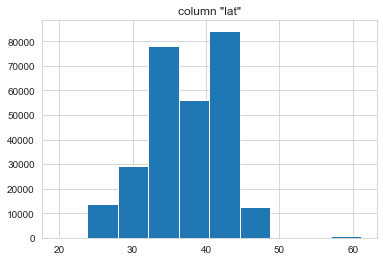

In [6]:
plt.title('column "lat"')
user_table['lat'].hist()
plt.show()

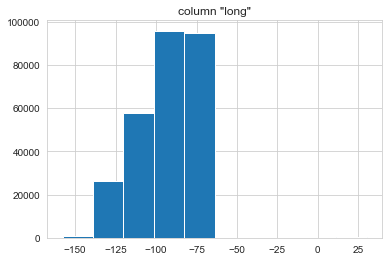

In [7]:
plt.title('column "long"')
user_table['long'].hist()
plt.show()

*Note: look good*

### Table: test_results

In [8]:
print('test_results:\n')
print(test_results.head())
# test_results.info()
# test_results.describe()

print('\ntest_results missing value:\n')
print(test_results.isnull().sum())

test_results:

   user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   

   test  price  converted  
0     0   39.0          0  
1     0   39.0          0  
2     0   39.0          0  
3     1   59.0          0  
4     0   39.0          0  

test_results missing value:

user_id                 0
timestamp             334
source                312
device                  0
operative_system    20339
test                    0
price                   0
converted               0
dtype: int64


*Note: three columns have missing values*

In [9]:
n_missing = test_results.isnull().sum()
n_total = len(test_results)
pct_missing = n_missing/n_total
pd.DataFrame({'column':n_missing.index,'N Missing':n_missing.values,'% Missing':pct_missing.values})

,column,N Missing,% Missing
0,user_id,0,0.000000
1,timestamp,334,0.001054
2,source,312,0.000985
3,device,0,0.000000
4,operative_system,20339,0.064201
5,test,0,0.000000
6,price,0,0.000000
7,converted,0,0.000000


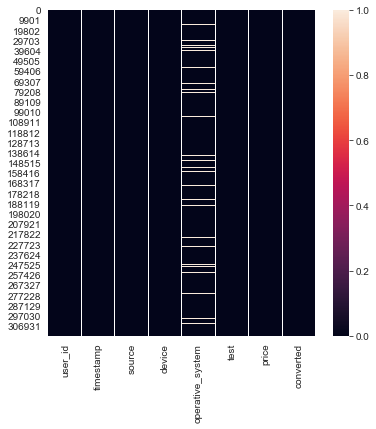

In [10]:
plt.figure(figsize=(6,6))
sns.heatmap(test_results.isnull())
plt.show()

**Drop rows contain nans for column "timestamp" and "source"**

In [11]:
test_results.dropna(subset=['timestamp','source'],inplace=True)
test_results.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system    20313
test                    0
price                   0
converted               0
dtype: int64

In [12]:
print('column "operative_system":\n')
print(test_results.groupby('operative_system')['user_id'].count().sort_values(ascending=False))

column "operative_system":

operative_system
windows    100667
iOS         95162
android     74692
mac         25002
i0S           113
wnddows        98
anroid         78
apple          29
Name: user_id, dtype: int64


**Correct Operative System Types**  
* mac OS
* iOS
* android
* windows

In [13]:
test_results['operative_system'] = test_results['operative_system'].astype(str).apply(
    lambda  x:x.replace('i0S','iOS').
                replace('wnddows','windows').
                replace('anroid','android').
                replace('mac','macOS').
                replace('apple','macOS'))

print('corrected "operative_system":\n')
print(test_results.groupby('operative_system')['user_id'].count().sort_values(ascending=False))

corrected "operative_system":

operative_system
windows    100765
iOS         95275
android     74770
macOS       25031
nan         20313
Name: user_id, dtype: int64


In [14]:
print('column "device":\n')
print(test_results.groupby('device')['operative_system'].value_counts())

print('\ncolumn "source":\n')
print(pd.pivot_table(test_results,values='user_id',index='source',columns=['device','operative_system'],aggfunc='count'))

column "device":

device  operative_system
mobile  iOS                  95275
        android              74770
        nan                  16047
web     windows             100765
        macOS                25031
        nan                   4266
Name: operative_system, dtype: int64

column "source":

device            mobile                web             
operative_system android    iOS   nan macOS  nan windows
source                                                  
ads-bing            5366   6909  1234  1723  274    7325
ads-google         13870  18118  2837  4705  891   18841
ads-yahoo           1761   2300   367   583   97    2454
ads_facebook       12381  16447  2788  4231  663   16770
ads_other           7035   8720  1565  2437  404    9649
direct_traffic     14622  18002  3083  4659  747   19126
friend_referral     4814   6321   887  1739  372    6521
seo-bing             496    708    97   163   13     669
seo-google          5532   6874  1292  1921  279    7237
seo-oth

**Drop rows contain nans for column "operative_system"**

*replace "nan" under "mobile" as "mobile_x"?*  
*replace "nan" under "web" as "web_x"?*

In [15]:
# test_results.dropna(subset=['operative_system'],inplace=True)
test_results = test_results[test_results['operative_system'] != 'nan']
test_results.groupby('device')['operative_system'].value_counts()

device  operative_system
mobile  iOS                  95275
        android              74770
web     windows             100765
        macOS                25031
Name: operative_system, dtype: int64

column "price":

AxesSubplot(0.125,0.125;0.775x0.755)


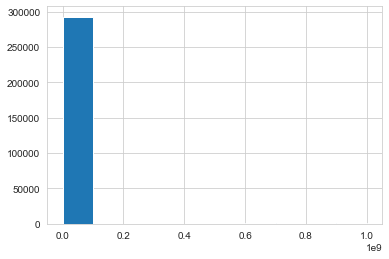

In [16]:
print('column "price":\n')
print(test_results['price'].hist())

*Note:  
"test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old, lower price)  
price: the price the user sees. It should match test"  
0 -> 39  
1 -> 59*

In [17]:
pd.pivot_table(test_results,values='user_id',index='price',columns=['test'],aggfunc='count')
# test_results.groupby('price')['user_id'].count().sort_values(ascending=False)

test,0,1
price,,
39.0,187661.0,141.0
59.0,187.0,105004.0
324680531.0,1.0,NaN
325355094.0,1.0,NaN
325373202.0,1.0,NaN
326160834.0,NaN,1.0
326183619.0,NaN,1.0
326312463.0,1.0,NaN
326480681.0,1.0,NaN


**Drop old "price" and create a new one**

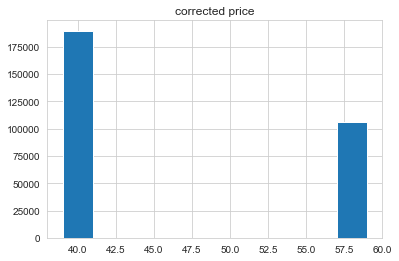

In [18]:
test_results['price'] = test_results['test'].apply(lambda x:39 if x==0 else 59)
plt.title('corrected price')
test_results['price'].hist()
plt.show()

In [19]:
print('column "timestamp":\n')
print(test_results['timestamp'].head())

column "timestamp":

0    2015-05-08 03:38:34
1    2015-05-10 21:08:46
2    2015-04-04 15:01:23
3    2015-05-07 07:26:01
4    2015-05-24 11:04:40
Name: timestamp, dtype: object


**create column "year", "month", and "day"**

In [20]:
test_results['year'] = test_results['timestamp'].apply(
    lambda s: int(s.split('-')[0]))
test_results['month'] = test_results['timestamp'].apply(
    lambda s: int(s.split('-')[1]))
test_results['day'] = test_results['timestamp'].apply(
    lambda s: int(s.split('-')[2].split(' ')[0]))

print('column "year":\n')
test_results['year'].value_counts()

column "year":



2015    295546
2815       295
Name: year, dtype: int64

*Note: Issue found, "2815" seems like a typo of "2015". Only one year worth of values, can drop it later*

**correct "year"**

In [21]:
test_results['year'] = 2015
test_results['year'].value_counts()

2015    295841
Name: year, dtype: int64

In [22]:
print('column "month" and "day":\n')
print(pd.pivot_table(test_results,values='user_id',index='day',columns='month',aggfunc='count'))

column "month" and "day":

month       3       4       5
day                          
1         NaN  1333.0  6647.0
2      1494.0  2694.0  5145.0
3      1407.0  6465.0  4005.0
4      1312.0  5432.0  1362.0
5      2630.0  3884.0  1489.0
6      6769.0  1317.0  1328.0
7      5341.0  1529.0  2674.0
8      4221.0  1421.0  6561.0
9      1377.0  2780.0  5387.0
10     1433.0  6612.0  4033.0
11     1258.0  5287.0  1323.0
12     2707.0  4240.0  1389.0
13     6707.0  1364.0  1391.0
14     5401.0  1416.0  2596.0
15     3773.0  1361.0  6801.0
16     1302.0  2661.0  5244.0
17     1410.0  6678.0  3930.0
18     1367.0  5190.0  1425.0
19     2632.0  4012.0  1426.0
20     6810.0  1301.0  1269.0
21     5454.0  1391.0  2561.0
22     3932.0  1419.0  6510.0
23     1386.0  2609.0  5401.0
24     1357.0  6654.0  3901.0
25     1491.0  5318.0  1312.0
26     2752.0  3853.0  1403.0
27     6626.0  1530.0  1223.0
28     5323.0  1404.0  2785.0
29     4020.0  1379.0  6532.0
30     1399.0  2628.0  5389.0
31     1227.0

*Note: look good*

**create column "datestamp"**

In [23]:
from datetime import datetime
test_results['datestamp'] = test_results.apply(
    lambda row:
    #datetime.strptime(
        str(row['year'])+'-'+str(row['month']).zfill(2)+'-'+str(row['day']).zfill(2)
        #,'%Y-%d-%m')
    , axis = 1)
test_results['datestamp'].head()

0    2015-05-08
1    2015-05-10
2    2015-04-04
3    2015-05-07
4    2015-05-24
Name: datestamp, dtype: object

*Note: column "minutes" and "seconds" have invalid value "60"*

### A/B Testing  
**Null hypothesis 1: increase of price does not decrease conversion rate**  
**Null hypothesis 2: increase of price does not increase revenue**

In [24]:
cr_by_day = pd.DataFrame(
    pd.pivot_table(test_results,index='datestamp',columns=['converted','test'],values='user_id',aggfunc='count'))
cr_by_day.columns = cr_by_day.columns.droplevel(0)
cr_by_day.columns.name = None
cr_by_day.columns = ['converted0_test0','converted0_test1','converted1_test0','converted1_test1']
cr_by_day['test0_rate'] = cr_by_day['converted1_test0']/(cr_by_day['converted1_test0']+cr_by_day['converted0_test0'])
cr_by_day['test1_rate'] = cr_by_day['converted1_test1']/(cr_by_day['converted1_test1']+cr_by_day['converted0_test1'])
cr_by_day['test0_revenue'] = cr_by_day['test0_rate'] * 39
cr_by_day['test1_revenue'] = cr_by_day['test1_rate'] * 59
cr_by_day.head()

,converted0_test0,converted0_test1,converted1_test0,converted1_test1,test0_rate,test1_rate,test0_revenue,test1_revenue
datestamp,,,,,,,,
2015-03-02,938,531,16,9,0.016771,0.016667,0.654088,0.983333
2015-03-03,851,530,20,6,0.022962,0.011194,0.895522,0.660448
2015-03-04,863,415,28,6,0.031425,0.014252,1.225589,0.840855
2015-03-05,1594,967,45,24,0.027456,0.024218,1.070775,1.428860
2015-03-06,4236,2412,79,42,0.018308,0.017115,0.714021,1.009780


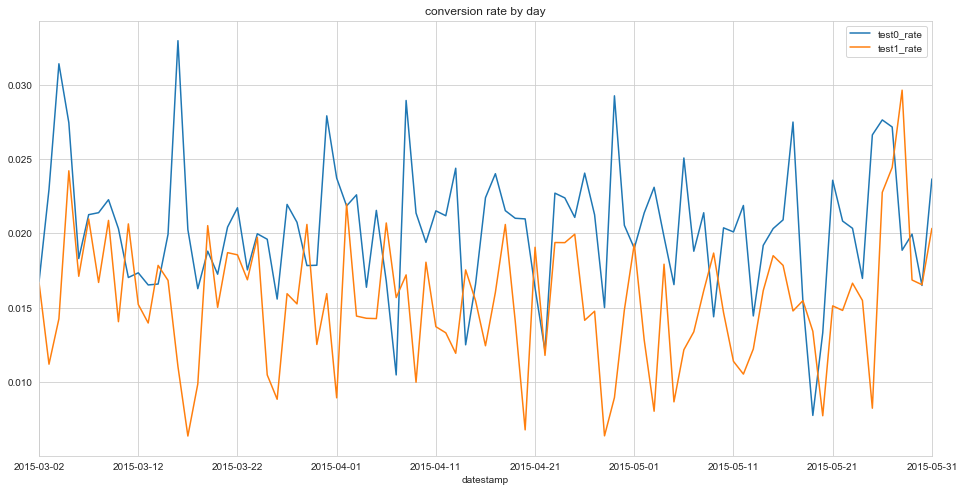

In [25]:
cr_by_day[['test0_rate','test1_rate']].plot(title = 'conversion rate by day', figsize = (16, 8))
plt.show()

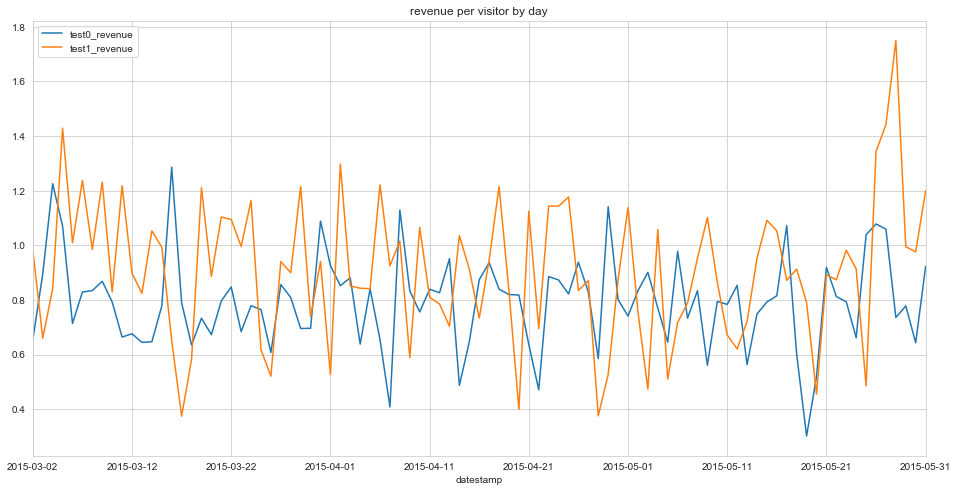

In [26]:
cr_by_day[['test0_revenue','test1_revenue']].plot(title = 'revenue per visitor by day', figsize = (16, 8))
plt.show()

*Note: look like overall test group 0 has higher conversion rates*

In [27]:
cr_by_day['d_rate'] = cr_by_day['test1_rate']-cr_by_day['test0_rate']
cr_by_day['d_revenue'] = cr_by_day['test1_revenue']-cr_by_day['test0_revenue']
cr_by_day.head()

,converted0_test0,converted0_test1,converted1_test0,converted1_test1,test0_rate,test1_rate,test0_revenue,test1_revenue,d_rate,d_revenue
datestamp,,,,,,,,,,
2015-03-02,938,531,16,9,0.016771,0.016667,0.654088,0.983333,-0.000105,0.329245
2015-03-03,851,530,20,6,0.022962,0.011194,0.895522,0.660448,-0.011768,-0.235075
2015-03-04,863,415,28,6,0.031425,0.014252,1.225589,0.840855,-0.017174,-0.384734
2015-03-05,1594,967,45,24,0.027456,0.024218,1.070775,1.428860,-0.003238,0.358085
2015-03-06,4236,2412,79,42,0.018308,0.017115,0.714021,1.009780,-0.001193,0.295759


**Wilcoxon Test**

In [28]:
from scipy.stats import wilcoxon

for index, row in cr_by_day.iterrows():
    # print(wilcoxon(cr_by_day['d'][:index], alternative='less'))
    cr_by_day.loc[index,'w'], cr_by_day.loc[index,'p_rate'] = wilcoxon(cr_by_day['d_rate'][:index], alternative='less')
    cr_by_day.loc[index,'w'], cr_by_day.loc[index,'p_revenue'] = wilcoxon(cr_by_day['d_revenue'][:index], alternative='greater')

//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [31]:
cr_by_day.head(100)

,converted0_test0,converted0_test1,converted1_test0,converted1_test1,test0_rate,test1_rate,test0_revenue,test1_revenue,d_rate,d_revenue,w,p_rate,p_revenue
datestamp,,,,,,,,,,,,,
2015-03-02,938,531,16,9,0.016771,0.016667,0.654088,0.983333,-0.000105,0.329245,1.0,1.586553e-01,0.158655
2015-03-03,851,530,20,6,0.022962,0.011194,0.895522,0.660448,-0.011768,-0.235075,2.0,8.985625e-02,0.327360
2015-03-04,863,415,28,6,0.031425,0.014252,1.225589,0.840855,-0.017174,-0.384734,2.0,5.440472e-02,0.703510
2015-03-05,1594,967,45,24,0.027456,0.024218,1.070775,1.428860,-0.003238,0.358085,5.0,3.394458e-02,0.500000
2015-03-06,4236,2412,79,42,0.018308,0.017115,0.714021,1.009780,-0.001193,0.295759,9.0,2.155722e-02,0.342915
2015-03-07,3314,1914,72,41,0.021264,0.020972,0.829297,1.237340,-0.000292,0.408043,15.0,1.385392e-02,0.172724
2015-03-08,2607,1531,57,26,0.021396,0.016699,0.834459,0.985228,-0.004698,0.150769,20.0,8.980239e-03,0.155247
2015-03-09,878,469,20,10,0.022272,0.020877,0.868597,1.231733,-0.001395,0.363136,27.0,5.859343e-03,0.103789
2015-03-10,916,491,19,7,0.020321,0.014056,0.792513,0.829317,-0.006265,0.036804,34.0,3.842897e-03,0.086535


**Null hypothesis 1: p-value of the Wilcoxon Test dropped below 0.01 at day 7**  
**Null hypothesis 2: p-value of the Wilcoxon Test dropped below 0.05 at day 9**

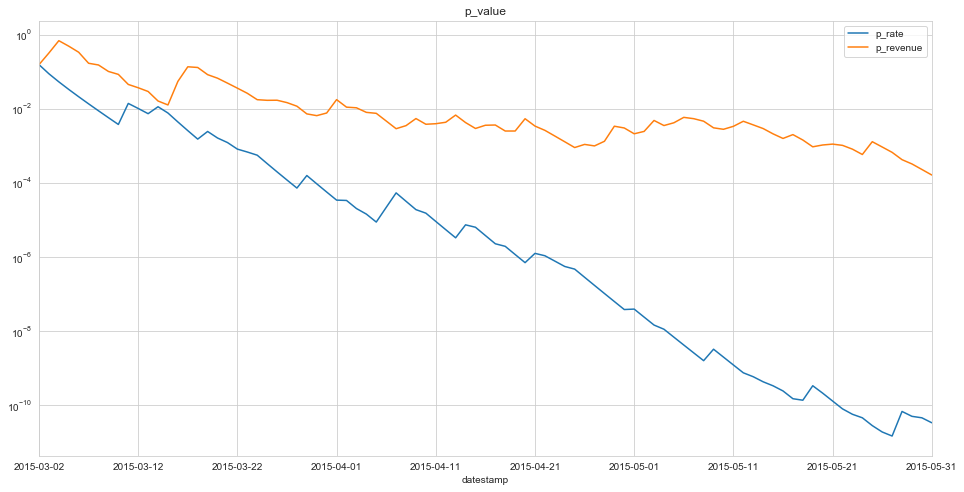

In [30]:
cr_by_day[['p_rate','p_revenue']].plot(title = 'p_value', figsize = (16, 8),logy=True)
plt.show()

**Both p-value dropped to a very low level at 2015-03-29**  
**Rate: 1.604078e-04**  
**Revenue: 0.007414**  

**merge two tables**

In [ ]:
user_merge = user_table.merge(test_results,on='user_id')
print('table user_merge:\n')
print(user_merge.head())

In [ ]:
ab_summary = pd.pivot_table(user_merge,values='user_id',index='test',columns='converted',aggfunc='count')
ab_summary['rate'] = ab_summary[1]/(ab_summary[0]+ab_summary[1])
print('conversion rates by test group:\n')
print(ab_summary)

sns.countplot(x='test',hue='converted',data=user_merge)
plt.show()

**Higher Price lowers the conversion rate!**  
**Higher Price increases revenues!**

# Who behave differently?

In [ ]:
user_merge.head()

In [ ]:
plt.figure(figsize=(16,4))
sns.barplot(x='source',y='converted',hue='test',data=user_merge)
plt.show()

*Note: "friend_referral" has the highest conversion rate*

In [ ]:
plt.figure(figsize=(4,4))
sns.barplot(x='device',y='converted',hue='test',data=user_merge)
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x='operative_system',y='converted',hue='test',data=user_merge)
plt.show()

*Note: "macOS" has the highest conversion rate*

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x='month',y='converted',hue='test',data=user_merge)
plt.show()

In [ ]:
plt.figure(figsize=(10,50))
sns.barplot(x='converted',y='city',hue='test',data=user_merge,order=city_head99_list)
plt.show()

In [ ]:
user_merge.head()
#sns.pairplot(user_merge)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

SEED = 101
TEST_SIZE = 0.2

def model_evaluation(y_test, predictions):
    print('Confusion Matrix\n\n{}'.format(confusion_matrix(y_test, predictions)))
    print('\n')
    print('Classification Report\n\n{}'.format(classification_report(y_test, predictions)))
    print('\n')
    print('Accuracy Score\n\n{}'.format(accuracy_score(y_test, predictions)))

X = pd.concat([user_merge.drop(['user_id','country','timestamp','price','converted','year','datestamp','city',
                                'source','device','operative_system'], axis = 1), 
       pd.get_dummies(user_merge[[#'city',
                                  'source','device','operative_system']],
                      drop_first = True#, dummy_na = True
                     )], axis = 1)
y = user_merge['converted']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size = TEST_SIZE, random_state = SEED)

# data scale
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# # SMOTE - Oversample
# from imblearn.over_sampling import SMOTE 
# sm = SMOTE(random_state = SEED)
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# # Undersample
# from imblearn.under_sampling import NearMiss
# # undersample = NearMiss(version=1, n_neighbors=3)
# undersample = NearMiss(version=2, n_neighbors=3)
# # undersample = NearMiss(version=3, n_neighbors_ver3=3)
# # undersample = TomekLinks()
# # undersample = EditedNearestNeighbours(n_neighbors=3)
# # undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
# # undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
# X_train_res, y_train_res = undersample.fit_resample(X_train, y_train)

# import xgboost as xgb
# data_dmatrix = xgb.DMatrix(data=X,label=y)
# xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
# xg_reg.fit(X_train,y_train)
# # xg_reg.fit(X_train_res,y_train_res)
# preds = xg_reg.predict(X_test)

# model_evaluation(y_test, preds)

In [ ]:
forest = RandomForestClassifier(random_state=SEED,class_weight={0: 0.98, 1: 0.02})
forest.fit(X_train, y_train)
preds = forest.predict(X_test)
model_evaluation(y_test, preds)

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
X.columns

*1 -> 'long'*  
*4 -> 'day'*  
*0 -> 'lat'*  
*3 -> 'month'*  
*2 -> 'test'*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[['source_ads-google',
       'source_ads-yahoo', 'source_ads_facebook', 'source_ads_other',
       'source_direct_traffic', 'source_friend_referral', 'source_seo-bing',
       'source_seo-google', 'source_seo-other', 'source_seo-yahoo',
       'source_seo_facebook', 'device_web', 'operative_system_iOS',
       'operative_system_macOS', 'operative_system_windows']], y, test_size=TEST_SIZE, random_state=SEED)
forest = RandomForestClassifier(random_state=42,class_weight={0: 0.98, 1: 0.02})
forest.fit(X_train, np.array(y_train))

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

*5 -> 'source_friend_referral'*  
*12 -> 'operative_system_iOS'*  
*4 -> 'source_direct_traffic'*  
*0 -> 'source_ads-google'*  
*2 -> 'source_ads_facebook'*